In [ ]:
from datetime import date
from silverfund.datasets.crsp_daily import CRSPDaily
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load CRSP daily data
start_date = date(1995, 7, 31)
end_date = date(2024, 12, 31)
crsp_daily = CRSPDaily(start_date=start_date, end_date=end_date).load_all()
print(crsp_daily)

Loading CRSP Daily years: 100%|██████████| 30/30 [00:05<00:00,  5.92it/s]


shape: (35_143_148, 14)
┌────────┬────────┬────────────┬──────────┬───┬───────────┬─────────────┬───────────┬─────────┐
│ permno ┆ permco ┆ date       ┆ ncusip   ┆ … ┆ retx      ┆ vol         ┆ shrout    ┆ cfacshr │
│ ---    ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---       ┆ ---         ┆ ---       ┆ ---     │
│ i64    ┆ i64    ┆ date       ┆ str      ┆   ┆ f64       ┆ f64         ┆ f64       ┆ f64     │
╞════════╪════════╪════════════╪══════════╪═══╪═══════════╪═════════════╪═══════════╪═════════╡
│ 10001  ┆ 7953   ┆ 1995-07-31 ┆ 29274A10 ┆ … ┆ 0.03125   ┆ 400.0       ┆ 2254.0    ┆ 1.5     │
│ 10001  ┆ 7953   ┆ 1995-08-01 ┆ 29274A10 ┆ … ┆ -0.015152 ┆ 0.0         ┆ 2254.0    ┆ 1.5     │
│ 10001  ┆ 7953   ┆ 1995-08-02 ┆ 29274A10 ┆ … ┆ 0.015385  ┆ 300.0       ┆ 2254.0    ┆ 1.5     │
│ 10001  ┆ 7953   ┆ 1995-08-03 ┆ 29274A10 ┆ … ┆ -0.060606 ┆ 250.0       ┆ 2254.0    ┆ 1.5     │
│ 10001  ┆ 7953   ┆ 1995-08-04 ┆ 29274A10 ┆ … ┆ 0.064516  ┆ 100.0       ┆ 2254.0    ┆ 1.5     │
│ …      ┆ …    

**EXERCISE 1**

In [4]:
# Ensure data is sorted by date for rolling calculations
crsp_daily = crsp_daily.sort(["permno", "date"])

# Compute log returns
crsp_daily_log = crsp_daily.with_columns((pl.col("ret") + 1).log().alias("log_ret"))
print(crsp_daily_log)

shape: (35_143_148, 15)
┌────────┬────────┬────────────┬──────────┬───┬─────────────┬───────────┬─────────┬───────────┐
│ permno ┆ permco ┆ date       ┆ ncusip   ┆ … ┆ vol         ┆ shrout    ┆ cfacshr ┆ log_ret   │
│ ---    ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---         ┆ ---       ┆ ---     ┆ ---       │
│ i64    ┆ i64    ┆ date       ┆ str      ┆   ┆ f64         ┆ f64       ┆ f64     ┆ f64       │
╞════════╪════════╪════════════╪══════════╪═══╪═════════════╪═══════════╪═════════╪═══════════╡
│ 10001  ┆ 7953   ┆ 1995-07-31 ┆ 29274A10 ┆ … ┆ 400.0       ┆ 2254.0    ┆ 1.5     ┆ 0.030772  │
│ 10001  ┆ 7953   ┆ 1995-08-01 ┆ 29274A10 ┆ … ┆ 0.0         ┆ 2254.0    ┆ 1.5     ┆ -0.015268 │
│ 10001  ┆ 7953   ┆ 1995-08-02 ┆ 29274A10 ┆ … ┆ 300.0       ┆ 2254.0    ┆ 1.5     ┆ 0.015268  │
│ 10001  ┆ 7953   ┆ 1995-08-03 ┆ 29274A10 ┆ … ┆ 250.0       ┆ 2254.0    ┆ 1.5     ┆ -0.06252  │
│ 10001  ┆ 7953   ┆ 1995-08-04 ┆ 29274A10 ┆ … ┆ 100.0       ┆ 2254.0    ┆ 1.5     ┆ 0.06252   │
│ …      ┆ …    

In [5]:
# Ensure data is sorted by date for rolling calculations
crsp_daily_log = crsp_daily_log.sort(["permno", "date"])

# Compute rolling sum of log returns for momentum signal within each stock (permno)
momentum_signal = crsp_daily_log.group_by(
    "permno", maintain_order=True
).agg(  # Group by stock # TODO: instead of doing a group by which will aggregate your code use .over()
    [
        pl.col("date"),
        pl.col("log_ret")
        .rolling_sum(window_size=252)
        .alias(
            "momentum_signal"
        ),  # 252-day rolling sum # TODO: I'm pretty sure the rolling window is 252 - 22 = 230
    ]
)

# Explode to ensure each row has a single value instead of lists
momentum_signal = momentum_signal.explode(["date", "momentum_signal"])

# Apply the 22-day shift for each stock separately
momentum_signal = (
    momentum_signal.sort(["permno", "date"])
    .with_columns(
        pl.col("momentum_signal").shift(22).over("permno")  # TODO: no need to alias it again
    )
    .drop_nulls()
)

# Pivot to make permno columns and date rows
momentum_wide = momentum_signal.pivot(index="date", on="permno", values="momentum_signal")
print(momentum_wide)

shape: (7_134, 15_170)
┌────────────┬──────────┬──────────┬──────────┬───┬───────┬───────────┬───────┬──────────┐
│ date       ┆ 10001    ┆ 10002    ┆ 10009    ┆ … ┆ 93433 ┆ 93434     ┆ 93435 ┆ 93436    │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---   ┆ ---       ┆ ---   ┆ ---      │
│ date       ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64   ┆ f64       ┆ f64   ┆ f64      │
╞════════════╪══════════╪══════════╪══════════╪═══╪═══════╪═══════════╪═══════╪══════════╡
│ 1996-08-27 ┆ 0.061487 ┆ 0.068539 ┆ 0.202206 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-08-28 ┆ 0.038378 ┆ 0.068539 ┆ 0.090827 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-08-29 ┆ 0.076289 ┆ 0.068539 ┆ 0.065564 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-08-30 ┆ 0.038378 ┆ 0.059279 ┆ 0.098354 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ 1996-09-03 ┆ 0.077731 ┆ 0.035748 ┆ 0.081112 ┆ … ┆ null  ┆ null      ┆ null  ┆ null     │
│ …          ┆ …        ┆ …        ┆ …        ┆ … ┆ …     ┆ …      

**EXERCISE 2**

In [1]:
# Drop nulls to ensure only valid momentum signals are used
momentum_signal_clean = momentum_signal.drop_nulls()

# Assign deciles based on momentum signal for each date
momentum_deciles = momentum_signal_clean.sort(
    ["date", "momentum_signal"]
).with_columns(  # Sort within each date  # TODO: I don't know what rank, ceil, and clip do but you could just just .cut(), honestly this might work. I just have not done it like this.
    (
        pl.col("momentum_signal").rank(method="ordinal").over("date")
        / pl.col("momentum_signal").count().over("date")
        * 10
    )
    .ceil()
    .clip(1, 10)  # Ensure values are between 1 and 10
    .alias("decile")
)  # TODO: you could check that this worked by doing a group_by(decile).agg(pl.col(permno).mean()) and each decile should have around 300-400 stocks.

# Display first few rows of the decile assignment
print(momentum_deciles)

NameError: name 'momentum_signal' is not defined

In [7]:
# Step 1: Filter stocks in top and bottom deciles
top_decile = momentum_deciles.filter(pl.col("decile") == 10)
bottom_decile = momentum_deciles.filter(pl.col("decile") == 1)

# Step 2: Merge with returns data to get stock returns
top_decile_returns = top_decile.join(crsp_daily_log, on=["permno", "date"], how="inner").select(
    ["date", "permno", "log_ret"]
)
bottom_decile_returns = bottom_decile.join(
    crsp_daily_log, on=["permno", "date"], how="inner"
).select(["date", "permno", "log_ret"])

# Step 3: Compute equal-weighted portfolio returns
top_portfolio = top_decile_returns.group_by("date").agg(
    pl.col("log_ret").mean().alias("top_portfolio_return")
)

bottom_portfolio = bottom_decile_returns.group_by("date").agg(
    pl.col("log_ret").mean().alias("bottom_portfolio_return")
)

# Merge both portfolios into a single DataFrame
portfolio_returns = top_portfolio.join(bottom_portfolio, on="date", how="inner")

# Compute long-short portfolio returns
long_short_portfolio = portfolio_returns.with_columns(
    (pl.col("top_portfolio_return") - pl.col("bottom_portfolio_return")).alias("long_short_return")
)

print(long_short_portfolio)

shape: (7_134, 4)
┌────────────┬──────────────────────┬─────────────────────────┬───────────────────┐
│ date       ┆ top_portfolio_return ┆ bottom_portfolio_return ┆ long_short_return │
│ ---        ┆ ---                  ┆ ---                     ┆ ---               │
│ date       ┆ f64                  ┆ f64                     ┆ f64               │
╞════════════╪══════════════════════╪═════════════════════════╪═══════════════════╡
│ 2022-10-04 ┆ 0.029107             ┆ 0.045309                ┆ -0.016202         │
│ 2015-12-14 ┆ -0.008837            ┆ -0.035461               ┆ 0.026624          │
│ 2004-10-28 ┆ -0.009782            ┆ 0.006419                ┆ -0.016202         │
│ 2012-05-10 ┆ 0.004175             ┆ -0.002642               ┆ 0.006817          │
│ 2000-11-14 ┆ 0.038767             ┆ 0.009791                ┆ 0.028976          │
│ …          ┆ …                    ┆ …                       ┆ …                 │
│ 2021-09-03 ┆ -0.008296            ┆ -0.010882           

In [8]:
# Shift portfolio returns forward by 1 day to hold the portfolio over the next day # TODO: Don't do this, your signal is already lagged, so you don't need to use forward returns.
long_short_held = long_short_portfolio.with_columns(
    pl.col("long_short_return").shift(-1).alias("long_short_held_return")
).drop_nulls()  # Drop last row where shifting creates NaN

print(long_short_held)

shape: (7_133, 5)
┌────────────┬─────────────────────┬─────────────────────┬───────────────────┬─────────────────────┐
│ date       ┆ top_portfolio_retur ┆ bottom_portfolio_re ┆ long_short_return ┆ long_short_held_ret │
│ ---        ┆ n                   ┆ turn                ┆ ---               ┆ urn                 │
│ date       ┆ ---                 ┆ ---                 ┆ f64               ┆ ---                 │
│            ┆ f64                 ┆ f64                 ┆                   ┆ f64                 │
╞════════════╪═════════════════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ 2022-10-04 ┆ 0.029107            ┆ 0.045309            ┆ -0.016202         ┆ 0.026624            │
│ 2015-12-14 ┆ -0.008837           ┆ -0.035461           ┆ 0.026624          ┆ -0.016202           │
│ 2004-10-28 ┆ -0.009782           ┆ 0.006419            ┆ -0.016202         ┆ 0.006817            │
│ 2012-05-10 ┆ 0.004175            ┆ -0.002642           ┆ 0.006817      

**DEBUGGING EX 2**

In [ ]:
# Total number of trading days
total_days = (long_short_held_agg["date"].max() - long_short_held_agg["date"].min()).days
annualized_return = (
    (long_short_cumulative[-1] ** (252 / total_days)) - 1
) * 100  # Convert to percentage

print(f"Annualized Return: {annualized_return:.2f}%")

Annualized Return: 36.23%


**Annualized is way too high**

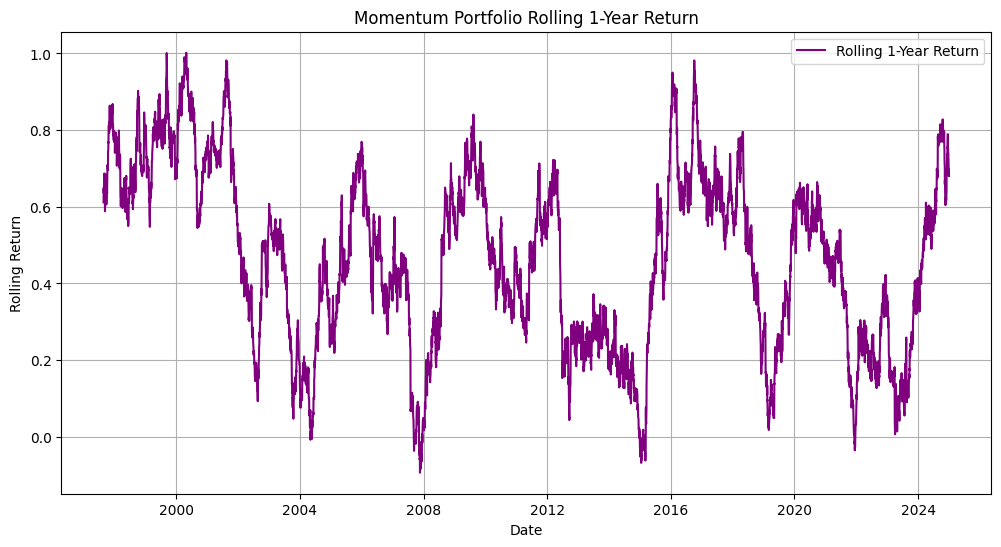

In [ ]:
rolling_window = 252  # 1-year rolling period
rolling_returns = long_short_held_agg.with_columns(
    pl.col("long_short_portfolio_return")
    .rolling_sum(window_size=rolling_window)
    .alias("rolling_1yr_return")
)

plt.figure(figsize=(12, 6))
plt.plot(
    rolling_returns["date"],
    rolling_returns["rolling_1yr_return"],
    label="Rolling 1-Year Return",
    color="purple",
)
plt.xlabel("Date")
plt.ylabel("Rolling Return")
plt.title("Momentum Portfolio Rolling 1-Year Return")
plt.legend()
plt.grid(True)
plt.show()

**Yearly return rarely goes below zero which is definitely seems fishy**

In [ ]:
risk_free_rate = 0.02  # Assuming 2% risk-free rate (can adjust based on T-bill rates)

# Compute Sharpe Ratio
excess_returns = long_short_held_agg["long_short_portfolio_return"] - (risk_free_rate / 252)
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 2.12


**No way there isnt an issue since sharpe ratio is 2+**

In [ ]:
# Ensure momentum signals are correctly sorted and shifted
momentum_signal_check = (
    momentum_signal.sort(["permno", "date"])
    .with_columns(
        pl.col("momentum_signal").shift(-22).over("permno").alias("future_momentum_signal")
    )
    .drop_nulls()  # Ensure no NaNs before computing correlation
)

# Compute Pearson correlation between current and future momentum signals
correlation_df = momentum_signal_check.select(
    pl.corr("momentum_signal", "future_momentum_signal").alias("correlation")
)

# Display correlation result
corr_value = correlation_df.item(0, 0)
print(f"Correlation between momentum signal and future values: {corr_value:.4f}")

Correlation between momentum signal and future values: 0.9200


**Okay the correlation is way to high**

**There is definitely something wrong**

**Exercise 3**

In [ ]:
# Step 1: Set ICi,t+1 = 0.05 for all stocks and dates
momentum_signal = momentum_signal.with_columns(pl.lit(0.05).alias("IC"))

# Step 2: Compute cross-sectional mean and standard deviation for each date
z_scores = momentum_signal.group_by("date").agg(
    [
        pl.col("momentum_signal").mean().alias("mean_signal"),
        pl.col("momentum_signal").std().alias("std_signal"),
    ]
)

# Merge Z-score calculations back into momentum_signal
momentum_signal = momentum_signal.join(z_scores, on="date", how="left")

# Compute Z-score
momentum_signal = momentum_signal.with_columns(
    ((pl.col("momentum_signal") - pl.col("mean_signal")) / pl.col("std_signal")).alias("Z_score")
)

# Step 3: Compute alpha values for each stock
momentum_signal = momentum_signal.with_columns((pl.col("IC") * pl.col("Z_score")).alias("alpha"))

# Step 4: Compute the self-financed portfolio weights
portfolio_weights = momentum_signal.group_by("date").agg(
    [pl.col("alpha").abs().sum().alias("sum_abs_alpha")]
)

# Merge sum_abs_alpha back into momentum_signal
momentum_signal = momentum_signal.join(portfolio_weights, on="date", how="left")

# Compute self-financed portfolio weights
momentum_signal = momentum_signal.with_columns(
    (pl.col("alpha") / pl.col("sum_abs_alpha")).alias("portfolio_weight")
)

In [ ]:
# Print sample of computed Z-scores
print(momentum_signal.select(["date", "permno", "momentum_signal", "Z_score"]).head())

# Print sample of alpha values
print(momentum_signal.select(["date", "permno", "Z_score", "IC", "alpha"]).head())

# Print sample of portfolio weights
print(momentum_signal.select(["date", "permno", "alpha", "portfolio_weight"]).head())

shape: (5, 4)
┌────────────┬────────┬─────────────────┬──────────┐
│ date       ┆ permno ┆ momentum_signal ┆ Z_score  │
│ ---        ┆ ---    ┆ ---             ┆ ---      │
│ date       ┆ i64    ┆ f64             ┆ f64      │
╞════════════╪════════╪═════════════════╪══════════╡
│ 1996-08-27 ┆ 10001  ┆ 0.061487        ┆ 0.109907 │
│ 1996-08-28 ┆ 10001  ┆ 0.038378        ┆ 0.07659  │
│ 1996-08-29 ┆ 10001  ┆ 0.076289        ┆ 0.145334 │
│ 1996-08-30 ┆ 10001  ┆ 0.038378        ┆ 0.056638 │
│ 1996-09-03 ┆ 10001  ┆ 0.077731        ┆ 0.120246 │
└────────────┴────────┴─────────────────┴──────────┘
shape: (5, 5)
┌────────────┬────────┬──────────┬──────┬──────────┐
│ date       ┆ permno ┆ Z_score  ┆ IC   ┆ alpha    │
│ ---        ┆ ---    ┆ ---      ┆ ---  ┆ ---      │
│ date       ┆ i64    ┆ f64      ┆ f64  ┆ f64      │
╞════════════╪════════╪══════════╪══════╪══════════╡
│ 1996-08-27 ┆ 10001  ┆ 0.109907 ┆ 0.05 ┆ 0.005495 │
│ 1996-08-28 ┆ 10001  ┆ 0.07659  ┆ 0.05 ┆ 0.00383  │
│ 1996-08-29 ┆ 100